Import necessary packages

In [1]:
import random
import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from sklearn import svm
from sklearn.externals import joblib
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.multiclass import OneVsRestClassifier
from sklearn.metrics import confusion_matrix, recall_score, precision_score
from sklearn.model_selection import train_test_split, cross_val_score

# Prepare the description dataset, which will be used for functional classification.

In [2]:
dataset = pd.read_csv('dataset/functional_classifier/description.csv')
def lower_stopwords(x):
    x = re.sub(r'[^a-zA-Z\s]', '', x, re.I|re.A)
    x = x.lower()
    x = x.strip()
    text_tokens = [word for word in word_tokenize(x) if word not in stopwords.words()]
    return " ".join(text_tokens)
dataset.drop('URL', 1, inplace=True)
dataset.drop('contributor', 1, inplace=True)
dataset.dropna(0, inplace=True)
dataset.reset_index(drop=True, inplace=True)
dataset["excerpt"] = dataset["excerpt"].apply(lower_stopwords)
X, y = dataset.excerpt, dataset.label

Split dataset into training and test data

In [3]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

Change text input into vectors to fit in SVM

In [4]:
vectorizer = CountVectorizer(binary=True)
X_vect_train = vectorizer.fit_transform(X_train).toarray()
X_vect_test =  vectorizer.transform(X_test).toarray() 

Prepare labels, change them into numbers to fit in the model. In this project, we will label each software as "Data Analysis" or "Data Management" or "Deep Learning".

In [5]:
y_train.replace('DA',0,inplace=True)
y_train.replace('DM',1,inplace=True)
y_train.replace('DL',2,inplace=True)
y_test.replace('DA',0,inplace=True)
y_test.replace('DM',1,inplace=True)
y_test.replace('DL',2,inplace=True)
y_train = y_train.astype('int')
y_test = y_test.astype('int')

# Try to use Gaussian Kernal to do the classification, 1-label-multi-class

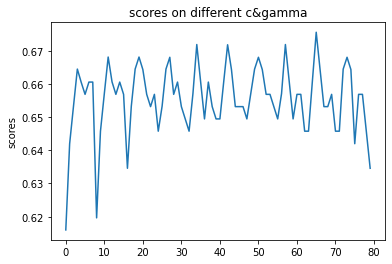

In [6]:
gamma_set = np.logspace(-3,-2,8)
c_set = np.logspace(1.8, 2.2, 10)
scores_set = {}
for c in c_set:
    for g in gamma_set:
        classifer = svm.SVC(C=c, kernel='rbf', gamma=g, decision_function_shape='ovr')
        score = cross_val_score(classifer, X_vect_train, y=y_train, cv=5).mean()
        scores_set['C={},gamma={}'.format(c,g)] = score
optimal_cg = max(zip(scores_set.values(), scores_set.keys()))
optimal_c = float(optimal_cg[1].split(',')[0].split('=')[1])
optimal_g = float(optimal_cg[1].split(',')[1].split('=')[1])

plt.plot([float(score) for score in scores_set.values()])
plt.title('scores on different c&gamma')
plt.ylabel('scores')
plt.show()

In [7]:
classifer = OneVsRestClassifier(svm.SVC(C=optimal_c,gamma=optimal_g, kernel='rbf'))
classifer.fit(X_vect_train,y_train)
y_pred = classifer.predict(X_vect_test)
print('Precision for Gaussian kernel',precision_score(np.array(y_test),y_pred,average='macro'))
print('Recall for Gaussian kernel', recall_score(np.array(y_test), y_pred, average='macro')  )
print('---Confusion matrix---')
print(confusion_matrix(np.array(y_test), y_pred))

from sklearn.metrics import jaccard_similarity_score
jaccard = jaccard_similarity_score(y_test, y_pred)
print(jaccard)

Precision for Gaussian kernel 0.6658232118758435
Recall for Gaussian kernel 0.5969553513413163
---Confusion matrix---
[[20  2  5]
 [ 9 11  1]
 [ 9  0 10]]
0.6119402985074627


Try to use Linear Kernal, L1 penalty.

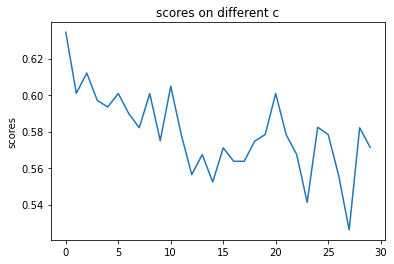

In [8]:
c_set = np.logspace(2, 4, 30)
scores_set = {}
for c in c_set:
    scv = svm.LinearSVC(penalty='l1',C=c,multi_class='ovr',dual=False) 
    scores = cross_val_score(scv, X_vect_train, y=y_train, cv=5).mean()
    scores_set["c={}".format(c)] = scores
optimal_c_l1 = float(max(zip(scores_set.values(), scores_set.keys()))[1].split('=')[1])

plt.plot([float(score) for score in scores_set.values()])
plt.title('scores on different c')
plt.ylabel('scores')
plt.show()

In [9]:
scv = OneVsRestClassifier(svm.LinearSVC(penalty='l1',C=optimal_c,dual=False))
scv.fit(X_vect_train,y_train)
y_pred = scv.predict(X_vect_test)
print('Precision for Gaussian kernel',precision_score(np.array(y_test),y_pred,average='macro'))
print('Recall for Gaussian kernel', recall_score(np.array(y_test), y_pred, average='macro')  )
print('---Confusion matrix---')
print(confusion_matrix(np.array(y_test), y_pred))

jaccard_l1 = jaccard_similarity_score(y_test, y_pred)
print(jaccard_l1)

Precision for Gaussian kernel 0.5346153846153846
Recall for Gaussian kernel 0.4121414647730437
---Confusion matrix---
[[21  2  4]
 [18  3  0]
 [13  0  6]]
0.44776119402985076


# Save the best model and test with new input

In [10]:
if jaccard_l1 > jaccard:
    joblib.dump(scv, "model/func_classifier.m")
else:
    joblib.dump(classifer, "model/func_classifier.m")

In [13]:
clf = joblib.load("model/func_classifier.m")
x_new_input = vectorizer.transform([input()]).toarray()
result = clf.predict(x_new_input)
if result == [0]:
    print('This should be a DATA ANALYSIS project.')
elif result == [1]:
    print('This should be a DATA MANAGEMENT project.')
elif result == [2]:
    print('This should be a DEEP LEARNING project.')

This should be a DEEP LEARNING project.
